In [278]:
# the next two lines will expand the printed tables
# pd.options.display.max_rows= 40000
# pd.options.display.max_columns= 40000

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp

In [298]:
DATA_FOLDER = "..\\data"
df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_091022_00.CSV"))

def tweak_fed(df):
    
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
             .set_index("t")
             .query("Event == 'Pellet'")
             .loc[:,"ipi"] # could use .loc[:,["ipi", "col2", "col5" etc]] to get mutliple columns, e.g. animal name etc
           )
#tweak_fed(df) # could add animal name from metafile and diet and phase so these are returned in dataframe

In [300]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\METAFILE FEDXC DATA SHEETS.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

ff_dict = {}
for row in rows:
    # file, mouse, diet, mode, sex,order,epoch = row
    fedfile, mouse, diet, mode, sex,order,epoch = row
    if (mode == "FF") and (diet in ["NR", "PR"]):
        key = "_".join([mouse, epoch])
        ff_dict[key] = {}
        ff_dict[key]["mouse"] = mouse
        ff_dict[key]["diet"] = diet
        ff_dict[key]["sex"] = sex
        ff_dict[key]["epoch"] = epoch
        ff_dict[key]["order"] = int(order)
        ff_dict[key]["pellets"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, fedfile)))
    


File is excel file. Making csv metafile first


In [301]:
ff_dict["FEDXC01_E1"]["pellets"].head(20)


t
2022-09-10 08:57:16      NaN
2022-09-10 09:00:18    182.0
2022-09-10 09:02:20    122.0
2022-09-10 09:03:01     41.0
2022-09-10 09:03:18     17.0
2022-09-10 09:03:44     26.0
2022-09-10 09:12:39    535.0
2022-09-10 09:13:30     51.0
2022-09-10 09:13:54     24.0
2022-09-10 09:20:51    417.0
2022-09-10 09:21:07     16.0
2022-09-10 09:21:23     16.0
2022-09-10 09:23:17    114.0
2022-09-10 09:24:04     47.0
2022-09-10 09:30:51    407.0
2022-09-10 09:32:41    110.0
2022-09-10 09:32:59     18.0
2022-09-10 09:33:08      9.0
2022-09-10 09:37:28    260.0
2022-09-10 09:37:43     15.0
Name: ipi, dtype: float64

In [302]:
(ff_dict["FEDXC01_E1"]["pellets"]
 .resample("d")
 .count()
 #.mean()
)

t
2022-09-10    160
2022-09-11    152
2022-09-12    153
2022-09-13    144
2022-09-14    141
2022-09-15    159
2022-09-16    167
2022-09-17    162
2022-09-18    167
2022-09-19     73
Freq: D, Name: ipi, dtype: int64

In [304]:
mice=[]
for key in ff_dict.keys():
    
    mouse= key.split("_")[0]
    if mouse not in mice:
        mice.append(mouse)

In [305]:
ff_dict_all_epochs={}
for mouse in mice:
    ff_dict_all_epochs[mouse]={}
    temp=[]
    for key, val in ff_dict.items():
        if mouse in key:
            temp.append(val["pellets"])
            ff_dict_all_epochs [mouse]["order"]= val["order"]
            
    ff_dict_all_epochs[mouse]["pellets"]=pd.concat(temp)       

In [312]:
ff_dict_all_epochs["FEDXC01"]["pellets"].head(50)

t
2022-09-10 08:57:16       NaN
2022-09-10 09:00:18     182.0
2022-09-10 09:02:20     122.0
2022-09-10 09:03:01      41.0
2022-09-10 09:03:18      17.0
2022-09-10 09:03:44      26.0
2022-09-10 09:12:39     535.0
2022-09-10 09:13:30      51.0
2022-09-10 09:13:54      24.0
2022-09-10 09:20:51     417.0
2022-09-10 09:21:07      16.0
2022-09-10 09:21:23      16.0
2022-09-10 09:23:17     114.0
2022-09-10 09:24:04      47.0
2022-09-10 09:30:51     407.0
2022-09-10 09:32:41     110.0
2022-09-10 09:32:59      18.0
2022-09-10 09:33:08       9.0
2022-09-10 09:37:28     260.0
2022-09-10 09:37:43      15.0
2022-09-10 09:38:24      41.0
2022-09-10 09:39:05      41.0
2022-09-10 09:39:26      21.0
2022-09-10 09:47:58     512.0
2022-09-10 09:51:37     219.0
2022-09-10 09:51:52      15.0
2022-09-10 09:52:16      24.0
2022-09-10 09:52:56      40.0
2022-09-10 09:54:03      67.0
2022-09-10 09:54:19      16.0
2022-09-10 10:00:05     346.0
2022-09-10 10:02:34     149.0
2022-09-10 10:02:51      17.0
2022-09-

In [289]:
ff_dict_all_epochs["FEDXC01"]["pellets"]

#I chnage the offset from 10H to 8H since the code was working in a weird manner and reading date from a day before the experiment begins!

def pellets_by_day(df,maxdays=30):
    return (df
            .rename(index="n_pellets")
            .resample("d", offset = "8H")
            .count()
            .head(maxdays)#We need to add the final two rows instead of deleting last row 
            #.reset_index()
            
           )

pellets_by_day(ff_dict_all_epochs["FEDXC01"]["pellets"])


#The original code by Jaime
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(pellets_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(pellets_by_day(val["pellets"]))

def clean_df(lst):
    return (pd.concat(lst, axis= 1)
           .fillna(0)
           .head(23)) #23 days used because in epoch 4 we used expired pellets for ctl animals





# NR= pd.concat(NR, axis=1)
# PR= pd.concat(PR, axis=1)

ctl_pellets= clean_df(ctl)
exp_pellets= clean_df(exp)
#We need to add the final two rows instead of deleting last row
#why one of the animals is starting a day later the others??

In [313]:
exp_pellets

# NR.to_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\STATS_FEDPROTEINPRO\NRresult.csv")

# PR.to_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\STATS_FEDPROTEINPRO\PRresult.csv")


,n_pellets,n_pellets,n_pellets,n_pellets,n_pellets,n_pellets
t,,,,,,
2022-09-10 08:00:00,234.0,285.0,224.0,0.0,263.0,254.0
2022-09-11 08:00:00,136.0,210.0,169.0,256.0,205.0,186.0
2022-09-12 08:00:00,150.0,188.0,151.0,226.0,180.0,190.0
2022-09-13 08:00:00,157.0,192.0,170.0,196.0,165.0,167.0
2022-09-14 08:00:00,143.0,184.0,176.0,229.0,125.0,162.0
2022-09-15 08:00:00,166.0,185.0,157.0,196.0,165.0,179.0
2022-09-16 08:00:00,157.0,191.0,171.0,203.0,213.0,172.0
2022-09-17 08:00:00,163.0,184.0,172.0,198.0,205.0,157.0
2022-09-18 08:00:00,170.0,178.0,170.0,193.0,198.0,164.0


In [326]:
#It is a copy of previous cell where I am trying to manipulate some lines



ff_dict_all_epochs["FEDXC01"]["pellets"]

#I chnage the offset from 10H to 8H since the code was working in a weird manner and reading date from a day before the experiment begins!

def pellets_by_day(df,maxdays=30):
    return (df
            .rename(index="n_pellets")
            .resample("d", offset = "8H")
            .count()
            .head(maxdays)#We need to add the final two rows instead of deleting last row 
            #.reset_index()
            
           )

pellets_by_day(ff_dict_all_epochs["FEDXC01"]["pellets"])


#The original code by Jaime
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(pellets_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(pellets_by_day(val["pellets"]))
# meanvalue = exp_pellets["n_pellets"].mean()

# def clean_df(lst):
#     return (pd.concat(lst, axis= 1)
#            .fillna(meanvalue)
#            .head(23)) #23 days used because in epoch 4 we used expired pellets for ctl animals

def clean_df(lst):
    return (pd.concat(lst, axis= 1)
           .fillna(0)
           .head(23)) #23 days used because in epoch 4 we used expired pellets for ctl animals
# for i in df.columns[df.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
#     df[i].fillna(df[i].mean(),inplace=True)
# df = df.groupby(df.columns, axis = 1).transform(lambda x: x.fillna(x.mean()))

# NR= pd.concat(NR, axis=1)
# PR= pd.concat(PR, axis=1)

ctl_pellets= clean_df(ctl)
exp_pellets= clean_df(exp)

#We need to add the final two rows instead of deleting last row
#why one of the animals is starting a day later the others??

In [327]:
exp_pellets

,n_pellets,n_pellets,n_pellets,n_pellets,n_pellets,n_pellets
t,,,,,,
2022-09-10 08:00:00,234.0,285.0,224.0,0.0,263.0,254.0
2022-09-11 08:00:00,136.0,210.0,169.0,256.0,205.0,186.0
2022-09-12 08:00:00,150.0,188.0,151.0,226.0,180.0,190.0
2022-09-13 08:00:00,157.0,192.0,170.0,196.0,165.0,167.0
2022-09-14 08:00:00,143.0,184.0,176.0,229.0,125.0,162.0
2022-09-15 08:00:00,166.0,185.0,157.0,196.0,165.0,179.0
2022-09-16 08:00:00,157.0,191.0,171.0,203.0,213.0,172.0
2022-09-17 08:00:00,163.0,184.0,172.0,198.0,205.0,157.0
2022-09-18 08:00:00,170.0,178.0,170.0,193.0,198.0,164.0


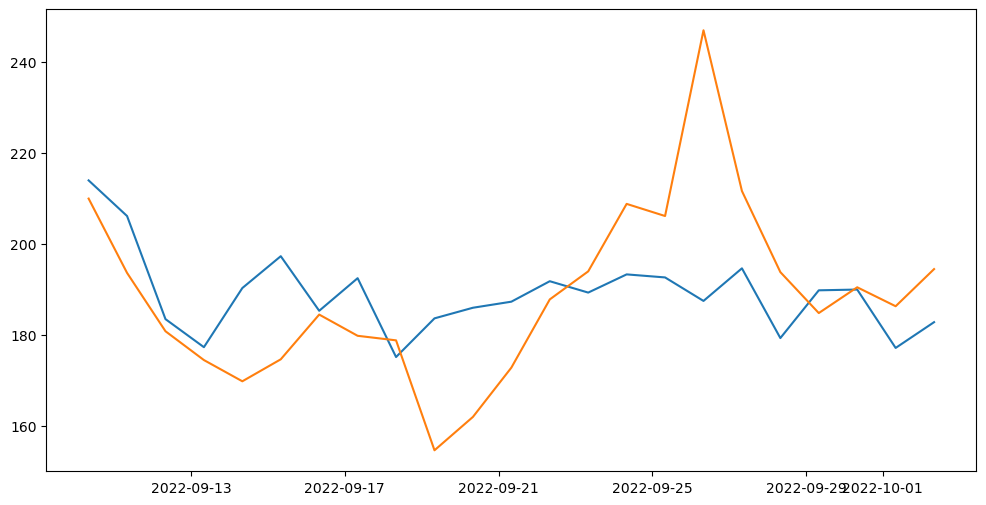

In [314]:
# NR.mean(axis=1)
# PR.mean(axis=1)

f, ax = plt.subplots(figsize=(12,6) )
ax.plot(ctl_pellets.mean(axis=1),) #yerror= NR.sem(axis=1))
ax.plot(exp_pellets.mean(axis=1))

In [315]:
len(ctl_pellets)

23

<AxesSubplot:xlabel='t'>

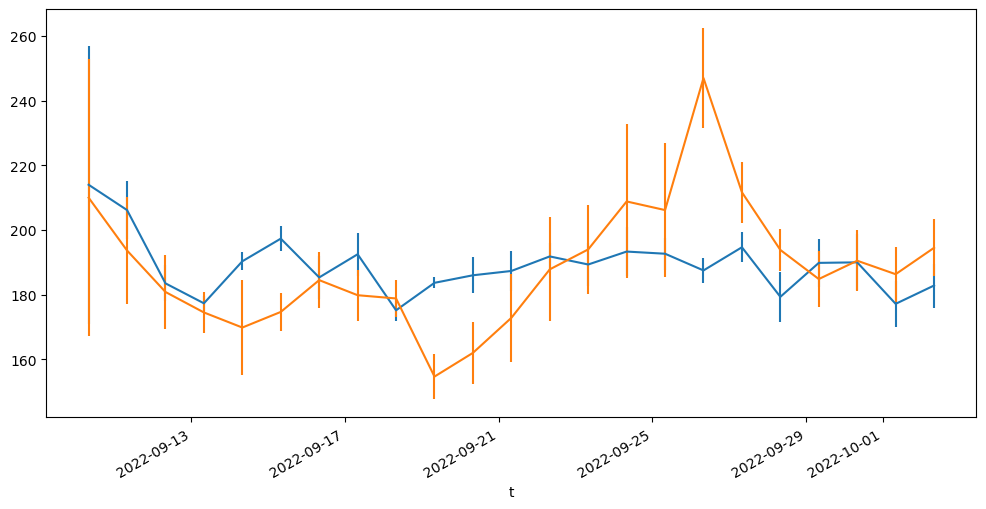

In [317]:
f, ax = plt.subplots(figsize=(12,6) )
ctl_pellets.mean(axis=1).plot(yerr= ctl_pellets.sem(axis=1), ax=ax)
exp_pellets.mean(axis=1).plot(yerr= exp_pellets.sem(axis=1), ax=ax)
#ax.set_xticks([0,1,2])

In [319]:
ff_dict_all_epochs["FEDXC01"]["pellets"]

# def calculate_meals(df):
#     return (df
            
        
def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )

ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))

ctl_n_meals= clean_df(ctl)

exp_n_meals= clean_df(exp)





<AxesSubplot:xlabel='t'>

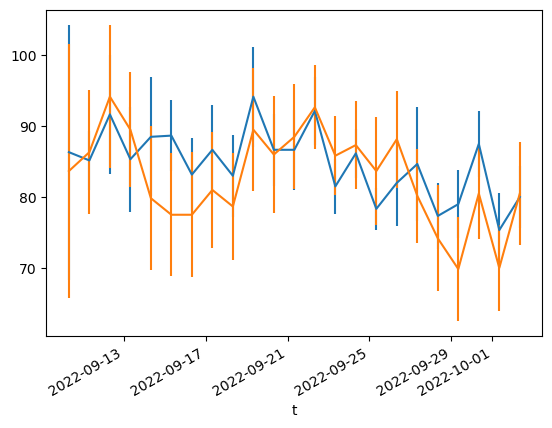

In [103]:
f, ax = plt.subplots()
ctl_n_meals.mean(axis=1).plot(yerr= ctl_n_meals.sem(axis=1), ax=ax)
exp_n_meals.mean(axis=1).plot(yerr= exp_n_meals.sem(axis=1), ax=ax)

In [104]:
def mealsize_by_day(df):
    return (df
            .rename(index="mealsize")
            .resample("d", offset = "8H")
            .apply(lambda df_: df_.count()/sum(df_ > 60))
            
#              .reset_index()
            
           )
#mealsize_by_day (ff_dict_all_epochs["FEDXC01"]["pellets"])


ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(mealsize_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(mealsize_by_day(val["pellets"]))

ctl_meal_size= clean_df(ctl)

exp_meal_size= clean_df(exp)



C:\Users\admin\AppData\Local\Temp\ipykernel_23348\4260347013.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  .apply(lambda df_: df_.count()/sum(df_ > 60))


<AxesSubplot:xlabel='t'>

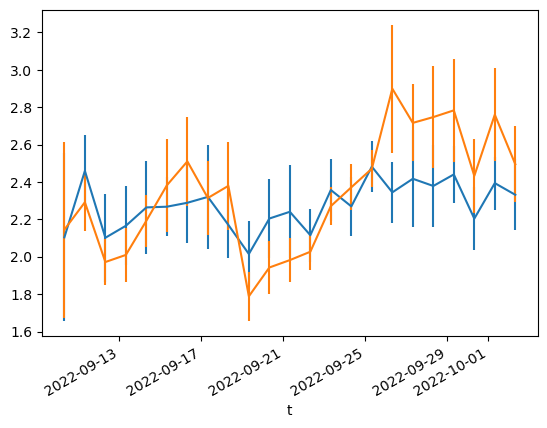

In [105]:
f, ax = plt.subplots()
ctl_meal_size.mean(axis=1).plot(yerr= ctl_meal_size.sem(axis=1), ax=ax)
exp_meal_size.mean(axis=1).plot(yerr= exp_meal_size.sem(axis=1), ax=ax)

<AxesSubplot:xlabel='t'>

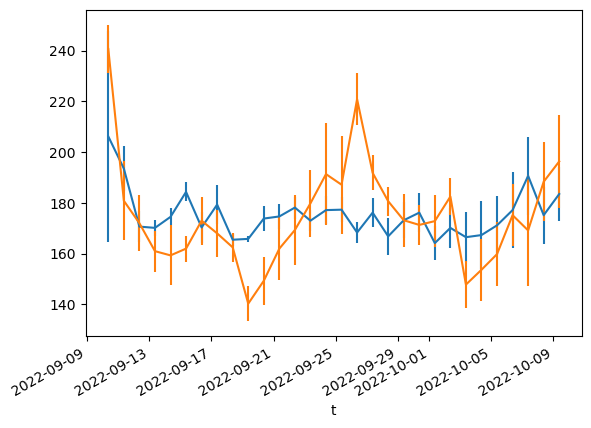

In [329]:
ff_dict_all_epochs["FEDXC01"]["pellets"]

def pellets_by_day(df):
    return (df
            .between_time("9:0", "7:0")
            .resample("d", offset = "9H")
            .count()
            #.reset_index()
            
           )

pellets_by_day(ff_dict_all_epochs["FEDXC01"]["pellets"])

NR=[]
PR=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        NR.append(pellets_by_day(val["pellets"]))
    elif val["order"] == 2:
        PR.append(pellets_by_day(val["pellets"]))
    
    


NR= pd.concat(NR, axis=1)
PR= pd.concat(PR, axis=1)


f, ax = plt.subplots()
NR.mean(axis=1).plot(yerr= NR.sem(axis=1), ax=ax)
PR.mean(axis=1).plot(yerr= PR.sem(axis=1), ax=ax)
#ax.set_xticks([0,1,2])

In [330]:
NR

,ipi,ipi,ipi,ipi,ipi,ipi
t,,,,,,
2022-09-10 09:00:00,0,230,248,251,261,247
2022-09-11 09:00:00,229,170,180,208,189,185
2022-09-12 09:00:00,189,152,157,178,164,184
2022-09-13 09:00:00,173,160,166,177,166,179
2022-09-14 09:00:00,172,177,175,160,178,185
2022-09-15 09:00:00,182,183,173,182,201,185
2022-09-16 09:00:00,159,175,156,165,169,198
2022-09-17 09:00:00,159,179,169,192,167,210
2022-09-18 09:00:00,155,169,166,165,167,171


In [109]:
NR.sem(axis=1)

t
2022-09-10 09:00:00    41.435425
2022-09-11 09:00:00     8.751190
2022-09-12 09:00:00     6.184209
2022-09-13 09:00:00     3.004626
2022-09-14 09:00:00     3.393621
2022-09-15 09:00:00     3.738687
2022-09-16 09:00:00     6.194980
2022-09-17 09:00:00     7.688375
2022-09-18 09:00:00     2.276694
2022-09-19 09:00:00     1.327069
2022-09-20 09:00:00     4.853979
2022-09-21 09:00:00     4.950870
2022-09-22 09:00:00     4.339099
2022-09-23 09:00:00     4.179314
2022-09-24 09:00:00     5.418589
2022-09-25 09:00:00     5.024385
2022-09-26 09:00:00     3.988873
2022-09-27 09:00:00     5.665196
2022-09-28 09:00:00     7.245305
2022-09-29 09:00:00     7.001984
2022-09-30 09:00:00     7.691626
2022-10-01 09:00:00     6.665417
2022-10-02 09:00:00     7.820557
2022-10-03 09:00:00     9.949037
2022-10-04 09:00:00    13.240510
2022-10-05 09:00:00    11.591424
2022-10-06 09:00:00    15.111622
2022-10-07 09:00:00    15.376750
2022-10-08 09:00:00    11.273617
2022-10-09 09:00:00    10.553830
Freq: D,

In [110]:
def make_ff_df(df, mouse, diet,order, epoch):
    """
    Takes df of pellets - time and IPIs - and returns row for collated df
    """
    out = pd.DataFrame.from_dict({"mouse": [mouse],
                                  "diet": [diet],
                                  "order" : [int(order)],
                                  "epoch" : [epoch],
                                   
                                  "n_pellets": [len(df)],
                                  "n_meals": (df > 60).sum(),
                                  "session_time": (df.index[-1] - df.index[0]).total_seconds() / 60,
                                  "short_ipis": (df < 5).sum()
                                  })

    return (out
           .assign(meal_freq=lambda df_: 1 / (df_.session_time / df_.n_meals) * 60 * 24,
                   meal_size=lambda df_: df_.n_pellets / df_.n_meals,
                   )
           .astype({"diet": "category",
                    "n_pellets": "uint16",
                    "n_meals": "uint16"}))

ff = pd.DataFrame()

for key, val in ff_dict.items():
    
    pellets = val["pellets"]
    mouse = val["mouse"]
    diet = val["diet"]
    order = val ["order"]
    epoch = val ["epoch"]
    ff = pd.concat([ff, make_ff_df(pellets, mouse, diet,order, epoch)])
    
ff.reset_index(drop=True, inplace=True);

 #ff_dict[key]["order"] = int(order)


In [111]:
ff

,mouse,diet,order,epoch,n_pellets,n_meals,session_time,short_ipis,meal_freq,meal_size
0,FEDXC01,NR,2,E1,1479,545,12947.350000,0,60.614720,2.713761
1,FEDXC01,PR,2,E2,1083,469,10074.316667,0,67.037797,2.309168
2,FEDXC01,NR,2,E3,1279,364,10076.800000,0,52.016513,3.513736
3,FEDXC01,PR,2,E4,1051,472,10004.750000,0,67.935731,2.226695
4,FEDXC02,NR,2,E1,1799,824,12927.316667,0,91.787030,2.183252
5,FEDXC02,PR,2,E2,1227,659,10066.550000,0,94.268642,1.861912
6,FEDXC02,NR,2,E3,1333,556,10075.400000,0,79.464835,2.397482
7,FEDXC02,PR,2,E4,1261,689,10013.383333,0,99.083393,1.830189
8,FEDXC03,NR,2,E1,1566,833,12935.433333,0,92.731335,1.879952
9,FEDXC03,PR,2,E2,1233,626,10042.650000,0,89.761169,1.969649


C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


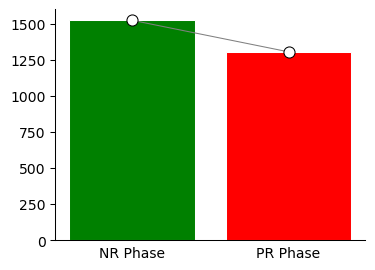

In [113]:
#plots all the pellets taken in PR and NR phases (combined) of Experimental group.

EXP_Pellets = ff.loc[ff["order"] == 2]
EXP_Pellets

EXP_Pellets_PR = EXP_Pellets.loc[EXP_Pellets["diet"] == "PR", ["n_pellets"]].mean()


EXP_Pellets_NR= EXP_Pellets.loc[EXP_Pellets["diet"] == "NR", ["n_pellets"]].mean()

EXP_Pellets_NR
EXP_Pellets_PR


# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (4, 3))
_, _, barlist, _ = tp.barscatter([EXP_Pellets_NR,EXP_Pellets_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "red"],
barlabels = ["NR Phase", "PR Phase"] )

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


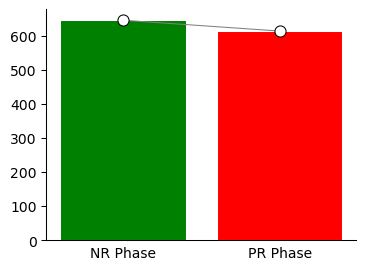

In [114]:
EXP_meal = ff.loc[ff["order"] == 2]
EXP_Pellets

EXP_meal_PR = EXP_Pellets.loc[EXP_Pellets["diet"] == "PR", ["n_meals"]].mean()


EXP_meal_NR= EXP_Pellets.loc[EXP_Pellets["diet"] == "NR", ["n_meals"]].mean()




# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (4, 3))
_, _, barlist, _ = tp.barscatter([EXP_meal_NR,EXP_meal_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "red"],
barlabels = ["NR Phase", "PR Phase"] )

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


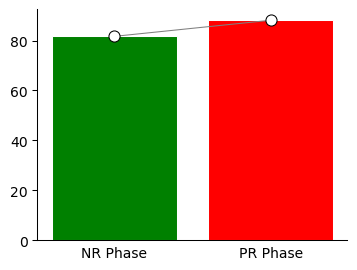

In [115]:
EXP_meal = ff.loc[ff["order"] == 2]


EXP_mealfreq_PR = EXP_Pellets.loc[EXP_Pellets["diet"] == "PR", ["meal_freq"]].mean()


EXP_mealfreq_NR= EXP_Pellets.loc[EXP_Pellets["diet"] == "NR", ["meal_freq"]].mean()




# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (4, 3))
_, _, barlist, _ = tp.barscatter([EXP_mealfreq_NR,EXP_mealfreq_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "red"],
barlabels = ["NR Phase", "PR Phase"] )

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


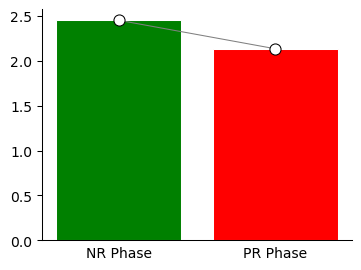

In [116]:
EXP_meal = ff.loc[ff["order"] == 2]


EXP_mealsize_PR = EXP_Pellets.loc[EXP_Pellets["diet"] == "PR", ["meal_size"]].mean()


EXP_mealsize_NR= EXP_Pellets.loc[EXP_Pellets["diet"] == "NR", ["meal_size"]].mean()




# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (4, 3))
_, _, barlist, _ = tp.barscatter([EXP_mealsize_NR,EXP_mealsize_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "red"],
barlabels = ["NR Phase", "PR Phase"] )

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


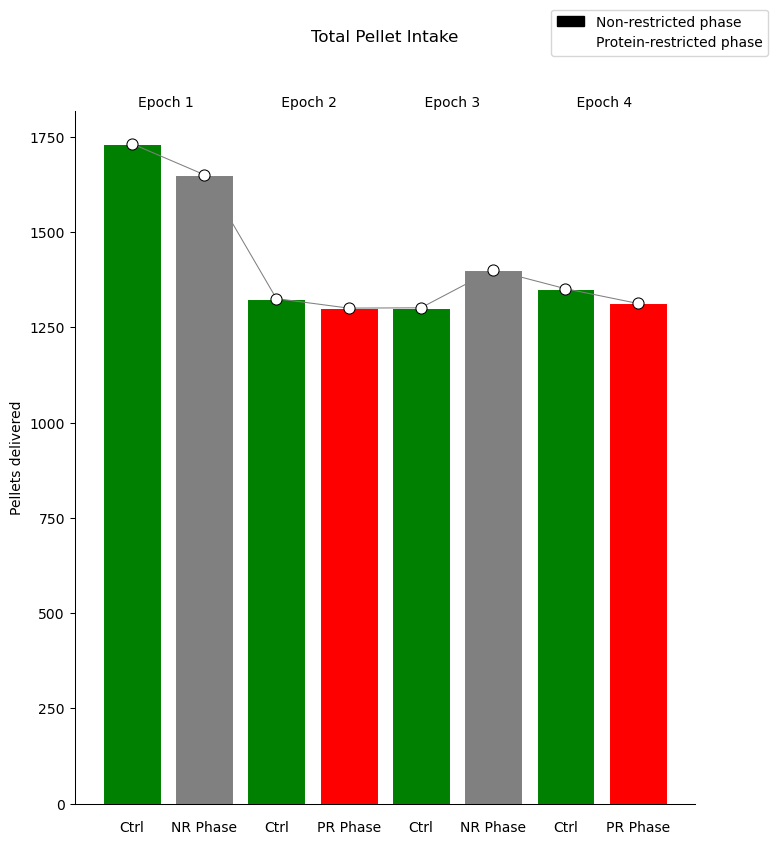

In [129]:
#trying to plot pellets taken by EXP mice during PR phase and CTL mice during NR phase


EXP_Pellets = ff.loc[ff["order"] == 2]
CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["n_pellets"]].mean()

CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["n_pellets"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["n_pellets"]].mean()

CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["n_pellets"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["n_pellets"]].mean()

CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["n_pellets"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["n_pellets"]].mean()

CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["n_pellets"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (8, 9))
_, _, barlist, _ = tp.barscatter([CTL_Pellets_E1_NR,EXP_Pellets_E1_NR,CTL_Pellets_E2_NR,EXP_Pellets_E2_PR,CTL_Pellets_E3_NR,EXP_Pellets_E3_NR,CTL_Pellets_E4_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "gray","green", "red","green", "gray","green", "red"],
barlabels = ["Ctrl", "NR Phase","Ctrl", "PR Phase","Ctrl", "NR Phase","Ctrl", "PR Phase",] )
ax.set_title("Total Pellet Intake", pad= 50)






secax = ax.secondary_xaxis('top', color = "black" )
secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
secax.tick_params(axis='x', colors='white') 
secax.spines['top'].set_color('white')
ax.set_ylabel("Pellets delivered",fontsize = 10)


fed_cols= ["black", "white"]
NR_patch = mpatches.Patch(color=fed_cols[0], label='Non-restricted phase')
PR_patch = mpatches.Patch(color=fed_cols[1], label='Protein-restricted phase')

ax.legend(handles=[NR_patch, PR_patch],
             bbox_to_anchor=(1, 1),
             bbox_transform=f.transFigure)
# ax.axes.secondary_xaxis.set_ticklabels([])
# # secax.yticks([])
# plt.show()
# # secax.set_axis_off()
# for side in ['top','right','bottom','left']:
#     ax.spines[side].set_visible(True)
# secax.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
# secax.set_yticks([min(y),max(y)]) 

In [127]:
(ctl_pellets
 .reset_index()
 .loc[2:8, :]
 .mean()
)

C:\Users\admin\AppData\Local\Temp\ipykernel_23348\3721546305.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  (ctl_pellets


n_pellets    179.285714
n_pellets    184.285714
n_pellets    179.000000
n_pellets    191.142857
n_pellets    184.714286
n_pellets    197.142857
dtype: float64

In [194]:
secax.set_xlabel??

Signature:
secax.set_xlabel(
    xlabel,
    fontdict=None,
    labelpad=None,
    *,
    loc=None,
    **kwargs,
)
Source:   
    def set_xlabel(self, xlabel, fontdict=None, labelpad=None, *,
                   loc=None, **kwargs):
        """
        Set the label for the x-axis.

        Parameters
        ----------
        xlabel : str
            The label text.

        labelpad : float, default: :rc:`axes.labelpad`
            Spacing in points from the Axes bounding box including ticks
            and tick labels.  If None, the previous value is left as is.

        loc : {'left', 'center', 'right'}, default: :rc:`xaxis.labellocation`
            The label position. This is a high-level alternative for passing
            parameters *x* and *horizontalalignment*.

        Other Parameters
        ----------------
        **kwargs : `.Text` properties
            `.Text` properties control the appearance of the label.

        See Also
        --------
        text : Documents 

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, '#Pellets/meal')

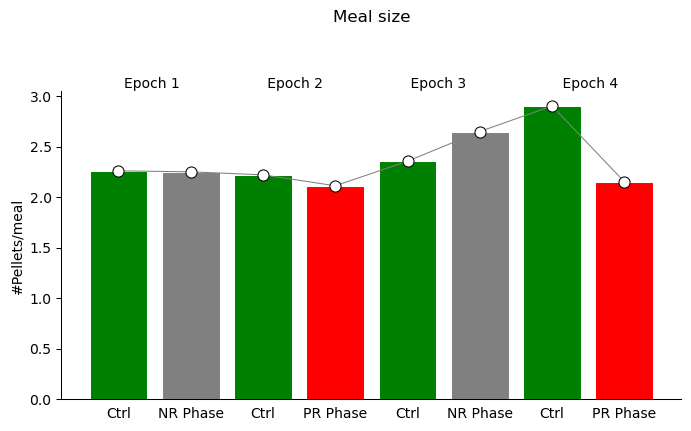

In [218]:
#trying to plot meal_size of EXP mice during PR phase and CTL mice during NR phase


EXP_Pellets = ff.loc[ff["order"] == 2]
CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["meal_size"]].mean()

CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["meal_size"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["meal_size"]].mean()

CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["meal_size"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["meal_size"]].mean()

CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["meal_size"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["meal_size"]].mean()

CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["meal_size"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


# f, ax = plt.subplots(figsize= (9, 7))
# _, _, barlist, _ = tp.barscatter([CTL_Pellets_E1_NR,EXP_Pellets_E1_NR,CTL_Pellets_E2_NR,EXP_Pellets_E2_PR,CTL_Pellets_E3_NR,EXP_Pellets_E3_NR,CTL_Pellets_E4_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
# barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "gray","green", "red","green", "gray","green", "red"],
# barlabels = ["Ctrl", "NR Phase","Ctrl", "PR Phase","Ctrl", "NR Phase","Ctrl","PR Phase"] )


f, ax = plt.subplots(figsize= (8, 4))
_, _, barlist, _ = tp.barscatter([CTL_Pellets_E1_NR,EXP_Pellets_E1_NR,CTL_Pellets_E2_NR,EXP_Pellets_E2_PR,CTL_Pellets_E3_NR,EXP_Pellets_E3_NR,CTL_Pellets_E4_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "gray","green", "red","green", "gray","green", "red"],
barlabels = ["Ctrl", "NR Phase","Ctrl", "PR Phase","Ctrl", "NR Phase","Ctrl", "PR Phase",] )
ax.set_title("Meal size", pad= 50)






secax = ax.secondary_xaxis('top', color = "black" )
secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
secax.tick_params(axis='x', colors='white') 
secax.spines['top'].set_color('white')
ax.set_ylabel("#Pellets/meal",fontsize = 10)

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, 'Meals/day(#)')

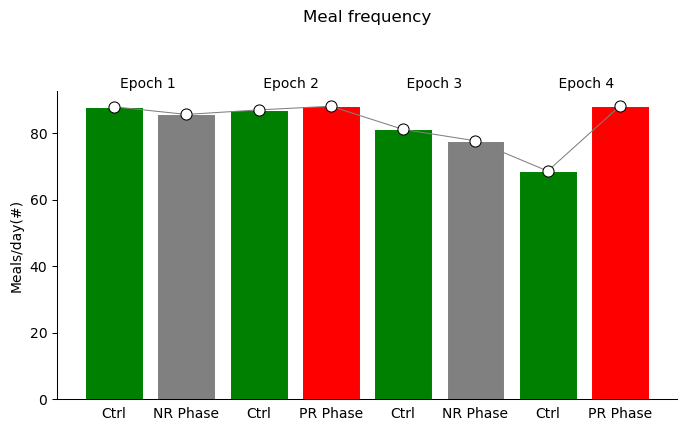

In [219]:
#trying to plot meal_freq of EXP mice during PR phase and CTL mice during NR phase


EXP_Pellets = ff.loc[ff["order"] == 2]
CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["meal_freq"]].mean()

CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["meal_freq"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["meal_freq"]].mean()

CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["meal_freq"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["meal_freq"]].mean()

CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["meal_freq"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["meal_freq"]].mean()

CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["meal_freq"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


# f, ax = plt.subplots(figsize= (9, 7))
# _, _, barlist, _ = tp.barscatter([CTL_Pellets_E1_NR,EXP_Pellets_E1_NR,CTL_Pellets_E2_NR,EXP_Pellets_E2_PR,CTL_Pellets_E3_NR,EXP_Pellets_E3_NR,CTL_Pellets_E4_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
# barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "gray","green", "red","green", "gray","green", "red"],
# barlabels = ["Ctrl", "NR Phase","Ctrl", "PR Phase","Ctrl", "NR Phase","Ctrl","PR Phase"] )

f, ax = plt.subplots(figsize= (8, 4))
_, _, barlist, _ = tp.barscatter([CTL_Pellets_E1_NR,EXP_Pellets_E1_NR,CTL_Pellets_E2_NR,EXP_Pellets_E2_PR,CTL_Pellets_E3_NR,EXP_Pellets_E3_NR,CTL_Pellets_E4_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "gray","green", "red","green", "gray","green", "red"],
barlabels = ["Ctrl", "NR Phase","Ctrl", "PR Phase","Ctrl", "NR Phase","Ctrl", "PR Phase",] )
ax.set_title("Meal frequency", pad= 50)






secax = ax.secondary_xaxis('top', color = "black" )
secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
secax.tick_params(axis='x', colors='white') 
secax.spines['top'].set_color('white')
ax.set_ylabel("Meals/day(#)",fontsize = 10)

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, '# meals')

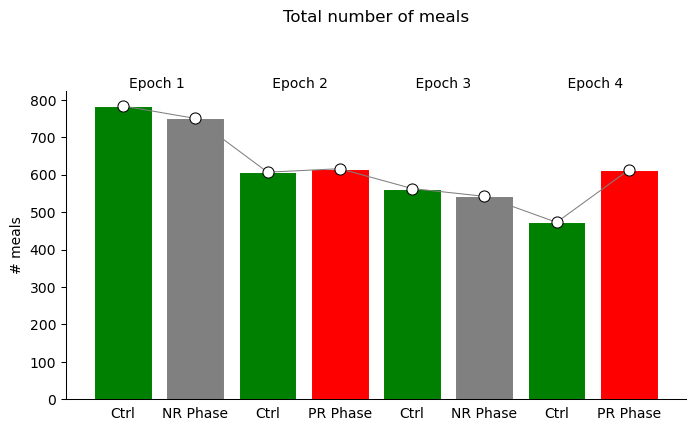

In [220]:
#trying to plot meal_freq of EXP mice during PR phase and CTL mice during NR phase


EXP_Pellets = ff.loc[ff["order"] == 2]
CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["n_meals"]].mean()

CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["n_meals"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["n_meals"]].mean()

CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["n_meals"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["n_meals"]].mean()

CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["n_meals"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["n_meals"]].mean()

CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["n_meals"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


# f, ax = plt.subplots(figsize= (9, 7))
# _, _, barlist, _ = tp.barscatter([CTL_Pellets_E1_NR,EXP_Pellets_E1_NR,CTL_Pellets_E2_NR,EXP_Pellets_E2_PR,CTL_Pellets_E3_NR,EXP_Pellets_E3_NR,CTL_Pellets_E4_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
# barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "gray","green", "red","green", "gray","green", "red"],
# barlabels = ["Ctrl", "NR Phase","Ctrl", "PR Phase","Ctrl", "NR Phase","Ctrl","PR Phase"] )


f, ax = plt.subplots(figsize= (8, 4))
_, _, barlist, _ = tp.barscatter([CTL_Pellets_E1_NR,EXP_Pellets_E1_NR,CTL_Pellets_E2_NR,EXP_Pellets_E2_PR,CTL_Pellets_E3_NR,EXP_Pellets_E3_NR,CTL_Pellets_E4_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "gray","green", "red","green", "gray","green", "red"],
barlabels = ["Ctrl", "NR Phase","Ctrl", "PR Phase","Ctrl", "NR Phase","Ctrl", "PR Phase",] )
ax.set_title("Total number of meals", pad= 50)






secax = ax.secondary_xaxis('top', color = "black" )
secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
secax.tick_params(axis='x', colors='white') 
secax.spines['top'].set_color('white')
ax.set_ylabel("# meals",fontsize = 10)

In [22]:
# get all IPIs for distribution histogram

all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna().clip(1))
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
        if data ["diet"] == "NR":
            NR_IPIS.append(data["pellets"].dropna().clip(1))
        elif  data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


68218

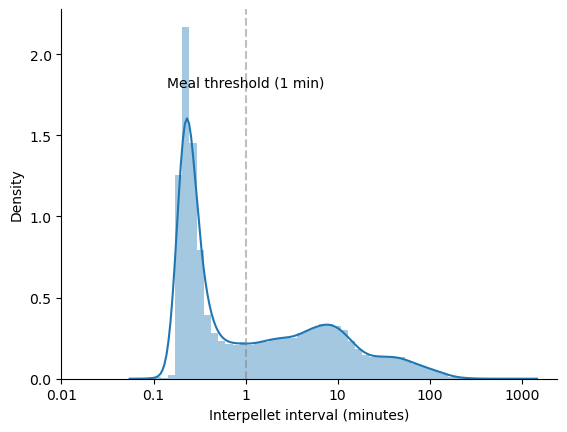

In [31]:
trans_ipis_ALL = [ipi for ipi in np.log10(ipis_ALL/60) if np.isfinite(ipi)]

f, ax = plt.subplots()
data = sns.distplot(trans_ipis_ALL)
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig("..\\results\\ipi_ff.png")
len(trans_ipis_ALL)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


52548

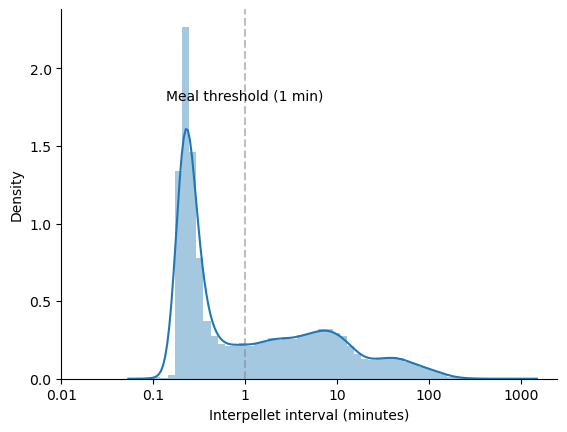

In [32]:
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]

f, ax = plt.subplots()
data = sns.distplot(trans_ipisNR)
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig("..\\results\\ipi_ff.png")

len(trans_ipisNR)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


15670

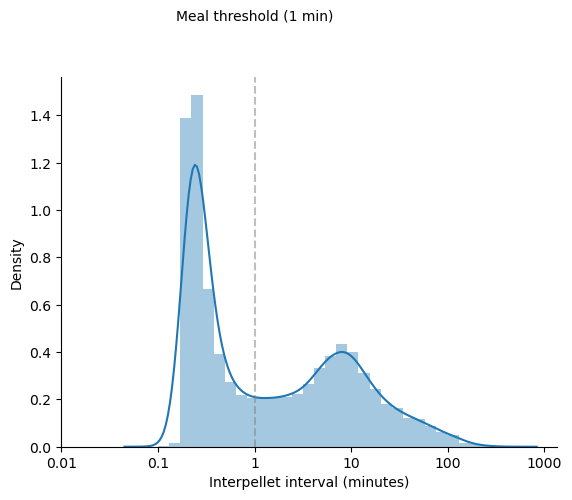

In [33]:
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]

f, ax = plt.subplots()
data = sns.distplot(trans_ipisPR)
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig("..\\results\\ipi_ff.png")
len(trans_ipisPR)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


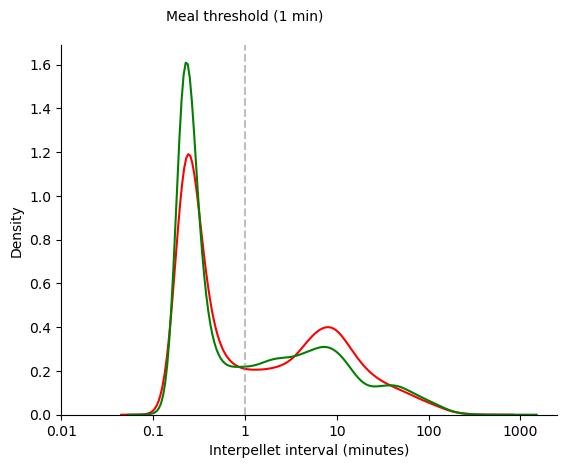

In [30]:
#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()
data = sns.distplot(trans_ipisPR, color= "red", hist = False )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

data = sns.distplot(trans_ipisNR, color = "green", hist = False )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

# data = sns.distplot(trans_ipisALL, color = "gold", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig("..\\results\\ipi_ff.png")



In [173]:
sns.distplot??

Signature:
sns.distplot(
    a=None,
    bins=None,
    hist=True,
    kde=True,
    rug=False,
    fit=None,
    hist_kws=None,
    kde_kws=None,
    rug_kws=None,
    fit_kws=None,
    color=None,
    vertical=False,
    norm_hist=False,
    axlabel=None,
    label=None,
    ax=None,
    x=None,
)
Source:   
def distplot(a=None, bins=None, hist=True, kde=True, rug=False, fit=None,
             hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None,
             color=None, vertical=False, norm_hist=False, axlabel=None,
             label=None, ax=None, x=None):
    """DEPRECATED: Flexibly plot a univariate distribution of observations.

    .. warning::
       This function is deprecated and will be removed in a future version.
       Please adapt your code to use one of two new functions:

       - :func:`displot`, a figure-level function with a similar flexibility
         over the kind of plot to draw
       - :func:`histplot`, an axes-level function for plotting histograms,
    

In [ ]:
f, ax = plt.subplots(figsize = (8,5.5), gridspec_kw= {"left":0.25,"bottom": 0.2})

interpellet_interval_plot([IPIs_m_nrpr_nr, IPIs_m_nrpr_pr],
                           colors=["green", "red"],
                           labels=["NRPR - NR pellets", "NRPR - PR pellets"],
                           linestyle="-",
                           fill=True,
                           ax=ax)

interpellet_interval_plot([IPIs_m_prnr_nr, IPIs_m_prnr_pr],
                           colors=["xkcd:kelly green", "pink"],
                           labels=["PRNR - NR pellets", "PRNR - PR pellets"],
                           linestyle="--",
                           fill=True,
                           ax=ax)

ax.legend(fontsize = 15)

#f.savefig(figfolder + "interpelletintervalmale.pdf")


# figfolder = r"C:\Users\hta031\OneDrive - UiT Office 365\Documents\People\Hamid\Educational Component\Midway_Evaluation\MIDWAY_PRESENTATION\FIGS\\"
# f.savefig(figfolder + "Kernel_all_groups.tif")

In [211]:
xls = pd.ExcelFile(r"C:\Users\hta031\Github\FEDPROTEINPRO\METAFILE FEDXC DATA SHEETS.xls")
dfmeta= pd.read_excel(xls,"METAFILE")


In [212]:
dfmeta

,fedfile,mouse,diet,mode,sex,order,epoch
0,FED001_091022_00.CSV,FEDXC01,NR,FF,M,2,E1
1,FED001_091922_00_MERGED.CSV,FEDXC01,PR,FF,M,2,E2
2,FED001_092622_00.CSV,FEDXC01,NR,FF,M,2,E3
3,FED001_100322_00.CSV,FEDXC01,PR,FF,M,2,E4
4,FED002_091022_00.CSV,FEDXC02,NR,FF,M,2,E1
5,FED002_091922_00.CSV,FEDXC02,PR,FF,M,2,E2
6,FED002_092622_00.CSV,FEDXC02,NR,FF,M,2,E3
7,FED002_100322_00.CSV,FEDXC02,PR,FF,M,2,E4
8,FED003_091022_00.CSV,FEDXC03,NR,FF,M,2,E1
9,FED003_091922_00.CSV,FEDXC03,PR,FF,M,2,E2
